## Random Forest Model for Credit Risk Prediction (Project version)
# ST 563 - Fall Semester 2025

### Import Libraries

In [96]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

### Load Data

In [97]:
# Load training data
train_data = pd.read_csv(r'E:\桌面\北卡金数\Fall sesmester 2\ST 563\credit_risk_train.csv')
X_train = train_data.drop('loan_status', axis=1)
y_train = train_data['loan_status']

# Load test data
test_data = pd.read_csv(r'E:\桌面\北卡金数\Fall sesmester 2\ST 563\credit_risk_test.csv')
X_test = test_data.drop('loan_status', axis=1)
y_test = test_data['loan_status']

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (26064, 12)
Test set: (6517, 12)



- Loads pre-split training and test datasets from CSV files
- Separates features (X) from target variable (y) for both sets
- The target variable is `loan_status` (0 = no default, 1 = default)

### Preprocess Data

In [98]:
# Fill missing values with median for numerical columns
numerical_cols = train_data.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    if train_data[col].isnull().any():
        median_val = train_data[col].median()
        train_data[col].fillna(median_val, inplace=True)
        test_data[col].fillna(median_val, inplace=True)

print(f"Missing values after: Train={train_data.isnull().sum().sum()}, Test={test_data.isnull().sum().sum()}")

# Cap employment length at 50 years (remove extreme outliers)
train_data.loc[train_data['person_emp_length'] > 50, 'person_emp_length'] = 50
test_data.loc[test_data['person_emp_length'] > 50, 'person_emp_length'] = 50

print(f"Max employment length after: {train_data['person_emp_length'].max():.1f} years")

# Drop first column if it's an index
if train_data.columns[0] == 'Unnamed: 0' or train_data.iloc[:, 0].name == '':
    train_data = train_data.iloc[:, 1:]
    test_data = test_data.iloc[:, 1:]

# Encode categorical variables
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on combined data to ensure same encoding
    combined = pd.concat([train_data[col], test_data[col]])
    le.fit(combined)
    train_data[col] = le.transform(train_data[col])
    test_data[col] = le.transform(test_data[col])

# Separate features and target
X_train = train_data.drop('loan_status', axis=1)
y_train = train_data['loan_status']

X_test = test_data.drop('loan_status', axis=1)
y_test = test_data['loan_status']

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Missing values after: Train=0, Test=0
Max employment length after: 50.0 years

X_train shape: (26064, 11)
X_test shape: (6517, 11)



- Handles missing values by filling with median for numerical columns
- Removes outliers by capping employment length at 50 years (previously had extreme values like 123 years)
- Drops unnecessary index column if present
- Encodes categorical variables into numbers using LabelEncoder with consistent mapping across train/test sets
- Separates features (X) from target variable (y)

### Train Model

In [99]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, min_samples_split=10,
                       n_jobs=-1, random_state=42)


- Creates a Random Forest model with 100 decision trees
- Sets hyperparameters to balance accuracy and prevent overfitting
- Trains the model on the training data (X_train, y_train)

**Hyperparameters:**
- `n_estimators=100`: Build 100 trees in the forest
- `max_depth=15`: Limit tree depth to prevent overfitting
- `min_samples_split=10`: Need at least 10 samples to split a node
- `min_samples_leaf=5`: Each leaf must have at least 5 samples
- `random_state=42`: For reproducibility
- `n_jobs=-1`: Use all CPU cores for faster training

### Make Predictions

In [100]:
y_train_pred = rf_model.predict(X_train)
y_train_proba = rf_model.predict_proba(X_train)[:, 1]

y_test_pred = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]


**Predictions generated:**
- `y_train_pred`: Predicted classes for training set (0=no default, 1=default)
- `y_train_proba`: Probability of default for training set (0.0 to 1.0)
- `y_test_pred`: Predicted classes for test set
- `y_test_proba`: Probability of default for test set

 `[:, 1]` extracts the probability of class 1 

### Evaluate Performance

In [101]:
print("\nTraining Set")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"AUC: {roc_auc_score(y_train, y_train_proba):.4f}")

print("\nTest Set")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

print("\nClassification Report")
print(classification_report(y_test, y_test_pred, target_names=['Non-default', 'Default']))



Training Set
Accuracy: 0.9381
AUC: 0.9827

Test Set
Accuracy: 0.9285
AUC: 0.9266

Classification Report
              precision    recall  f1-score   support

 Non-default       0.92      0.99      0.96      5123
     Default       0.96      0.69      0.81      1394

    accuracy                           0.93      6517
   macro avg       0.94      0.84      0.88      6517
weighted avg       0.93      0.93      0.92      6517




**What this does:**
Evaluates the trained Random Forest model on both training and test sets using accuracy and AUC metrics, then generates a detailed classification report.

**Results:**
The model achieves strong performance with training accuracy of 93.81% and test accuracy of 92.85%, showing minimal overfitting. The AUC scores are excellent at 0.9827 for training and 0.9266 for testing, indicating the model has strong ability to distinguish between defaulters and non-defaulters.

Looking at the classification report for the test set, the model performs exceptionally well at identifying non-default loans with 99% recall and 92% precision, meaning it catches almost all good loans. For default predictions, the model shows high precision at 96% but moderate recall at 69%, meaning when it predicts a default it's usually correct, but it misses about 31% of actual defaults. The overall F1-scores are 0.96 for non-defaults and 0.81 for defaults, with an overall accuracy of 93%. This suggests the model is conservative in flagging defaults, prioritizing precision over recall to avoid false alarms.

### Confusion Matrix

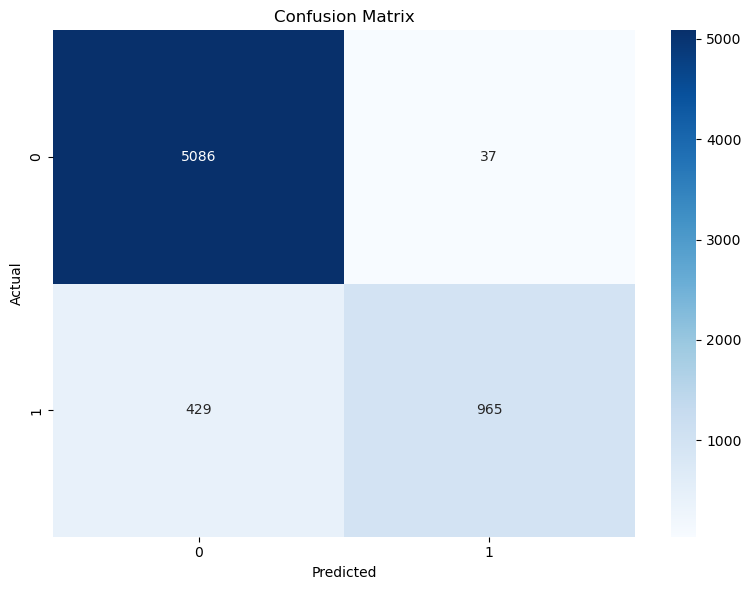

In [109]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()


Creates a confusion matrix visualization to show how the model's predictions compare to actual results, breaking down correct and incorrect predictions into four categories.

**Results:**
The confusion matrix reveals the model correctly identified 5,086 non-default loans (true negatives) and 965 default loans (true positives). However, it made 37 false positive errors by incorrectly flagging non-defaults as defaults, and 429 false negative errors by missing actual defaults. This visualization confirms the pattern seen in the classification report where the model is highly accurate at identifying good loans but more conservative with defaults, prioritizing precision to minimize false alarms at the cost of missing some actual defaults. The dark blue color in the top-left corner shows the model's strength in correctly predicting non-defaults, while the lighter blue in the bottom-left indicates the area where improvement is needed in catching more defaults.

### Feature Importance


--- Feature Importance ---
                       Feature  Importance
8          loan_percent_income    0.275310
5                   loan_grade    0.143203
1                person_income    0.138493
2        person_home_ownership    0.127383
7                loan_int_rate    0.107528
4                  loan_intent    0.069784
6                    loan_amnt    0.050975
3            person_emp_length    0.044376
0                   person_age    0.017691
10  cb_person_cred_hist_length    0.014322
9    cb_person_default_on_file    0.010936


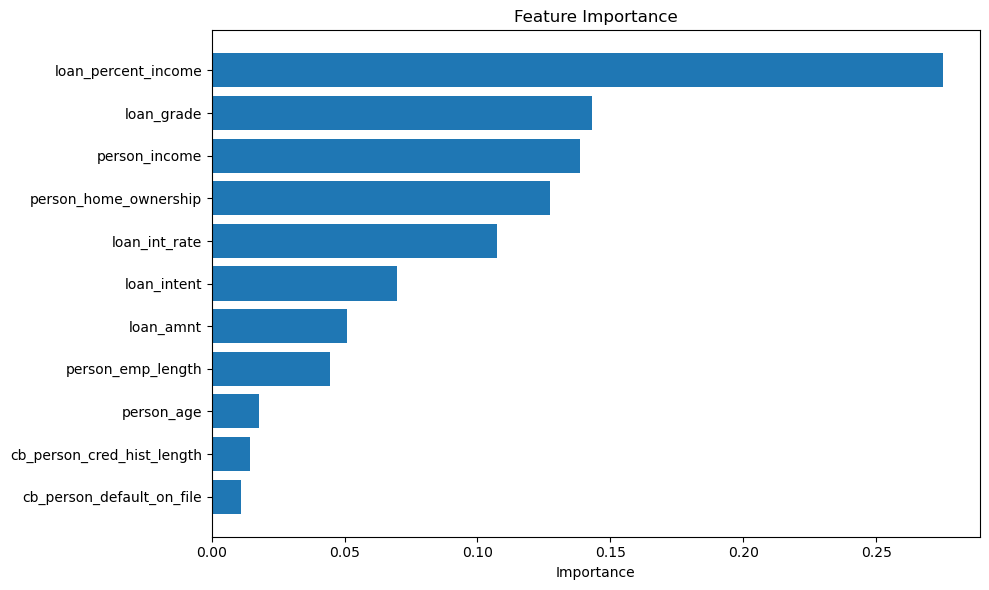

In [111]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n--- Feature Importance ---")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Deep Learning Method Comparsion

#### Problem Formalization
**Problem Typ** Binary Classification
**Dataset Descriptn:**
This dataset contains credit risk information for loan applications. Each row represents a borrower with features including:
- Personal information: age, income, employment length, home ownership
- Loan details: intent, grade, amount, interest rate, percent of income
- Credit history: default history, credit history ngth

**Targetriable:** 
- `loan_status`: Binary outcome (0 = Non-default, 1 =efault)

**taset Size:**
- Training set: 26,064 samples
- Test set: 6,517 samples (fixed for all experiments)
- Features: 11 (after eprocessing)

**Peormance Metrics:**
- **Primy metric: AUC-ROC** - Measures the model's ability to distinguish between defaulters and non-defaulters, less sensitive to class imbalance
- **Secondary metric: Accuracy** - Overall correctness of predictions

The goal is to predict whether a borrower will default on their loan based on these features.

### Package Update

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score  # add this
import warnings
warnings.filterwarnings('ignore')

batch_size = 128
epochs = 50
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

### Data Handling

In [77]:
from sklearn.preprocessing import StandardScaler

# Load training and test data
train_data = pd.read_csv(r'E:\桌面\北卡金数\Fall sesmester 2\ST 563\credit_risk_train.csv')
test_data = pd.read_csv(r'E:\桌面\北卡金数\Fall sesmester 2\ST 563\credit_risk_test.csv')

# Fill missing values with median
for col in train_data.select_dtypes(include=[np.number]).columns:
    if train_data[col].isnull().any():
        median = train_data[col].median()
        train_data[col].fillna(median, inplace=True)
        test_data[col].fillna(median, inplace=True)

# Cap employment length at 50 years
train_data.loc[train_data['person_emp_length'] > 50, 'person_emp_length'] = 50
test_data.loc[test_data['person_emp_length'] > 50, 'person_emp_length'] = 50

# Drop index column if exists
if train_data.columns[0] == 'Unnamed: 0':
    train_data = train_data.iloc[:, 1:]
    test_data = test_data.iloc[:, 1:]

# Encode categorical variables
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_data[col], test_data[col]])
    le.fit(combined)
    train_data[col] = le.transform(train_data[col])
    test_data[col] = le.transform(test_data[col])

# Separate features and target
X_train = train_data.drop('loan_status', axis=1).values.astype(np.float32)
y_train = train_data['loan_status'].values.astype(np.int64)
X_test = test_data.drop('loan_status', axis=1).values.astype(np.float32)
y_test = test_data['loan_status'].values.astype(np.int64)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (26064, 11), Test: (6517, 11)


###  Model

In [83]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        # input layer: 11 features -> 64 neurons
        self.fc1 = nn.Linear(11, 64)
        # hidden layer: 64 -> 32 neurons
        self.fc2 = nn.Linear(64, 32)
        # output layer: 32 -> 1 neuron
        self.fc3 = nn.Linear(32, 1)
        # dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # first layer with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # second layer with ReLU activation
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # output layer with Sigmoid activation
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze()

### Training Functions

In [85]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()                         # training mode
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device) # move to device
        pred = model(x)                   # forward
        loss = criterion(pred, y.float()) # loss
        optimizer.zero_grad()             # reset grads
        loss.backward()                   # backprop
        optimizer.step()                  # update
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)  # mean loss


@torch.no_grad()
def evaluate(model, x, y):
    model.eval()                          # eval mode
    x_tensor = torch.from_numpy(x).to(device)
    pred = model(x_tensor).cpu().numpy()  # forward -> numpy
    acc = accuracy_score(y, (pred > 0.5).astype(int))  # threshold
    auc = roc_auc_score(y, pred)          # AUC
    return acc, auc


### Experiment with Different Data Sizes

In [95]:
fractions = [1.0, 0.5, 0.25, 0.125, 0.0625]
results = []

# Previous Random Forest results (from your project)
rf_previous_results = {
    'train_auc': 0.9827,
    'test_auc': 0.9266,
    'test_acc': 0.9285
}

for frac in fractions:
    print(f"\nTraining with {frac*100:.0f}% data:")
    
    # Sample data
    if frac < 1.0:
        X_sub, _, y_sub, _ = train_test_split(X_train, y_train, train_size=frac, stratify=y_train, random_state=42)
    else:
        X_sub, y_sub = X_train, y_train
    
    # Train Deep Learning model
    train_dataset = TensorDataset(torch.from_numpy(X_sub), torch.from_numpy(y_sub))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model = MLP().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    
    for epoch in range(epochs):
        loss = train_one_epoch(model, train_loader, optimizer, criterion)
    
    dl_train_acc, dl_train_auc = evaluate(model, X_sub, y_sub)
    dl_test_acc, dl_test_auc = evaluate(model, X_test, y_test)
    
    print(f"DL: Train AUC={dl_train_auc:.4f}, Test AUC={dl_test_auc:.4f}")
    
    # For full data, show comparison with previous RF results
    if frac == 1.0:
        print(f"RF (Previous): Train AUC={rf_previous_results['train_auc']:.4f}, Test AUC={rf_previous_results['test_auc']:.4f}")
    
    results.append({
        'n': len(X_sub),
        'dl_train': dl_train_auc,
        'dl_test': dl_test_auc,
        'dl_test_acc': dl_test_acc
    })

df = pd.DataFrame(results)
print("\n", df)


Training with 100% data:
DL: Train AUC=0.8804, Test AUC=0.8771
RF (Previous): Train AUC=0.9827, Test AUC=0.9266

Training with 50% data:
DL: Train AUC=0.8725, Test AUC=0.8695

Training with 25% data:
DL: Train AUC=0.8655, Test AUC=0.8562

Training with 12% data:
DL: Train AUC=0.8497, Test AUC=0.8438

Training with 6% data:
DL: Train AUC=0.8121, Test AUC=0.8105

        n  dl_train   dl_test  dl_test_acc
0  26064  0.880441  0.877063     0.869879
1  13032  0.872504  0.869550     0.861439
2   6516  0.865506  0.856193     0.853614
3   3258  0.849688  0.843821     0.841645
4   1629  0.812149  0.810481     0.815406


### Visualization with RF Comparison

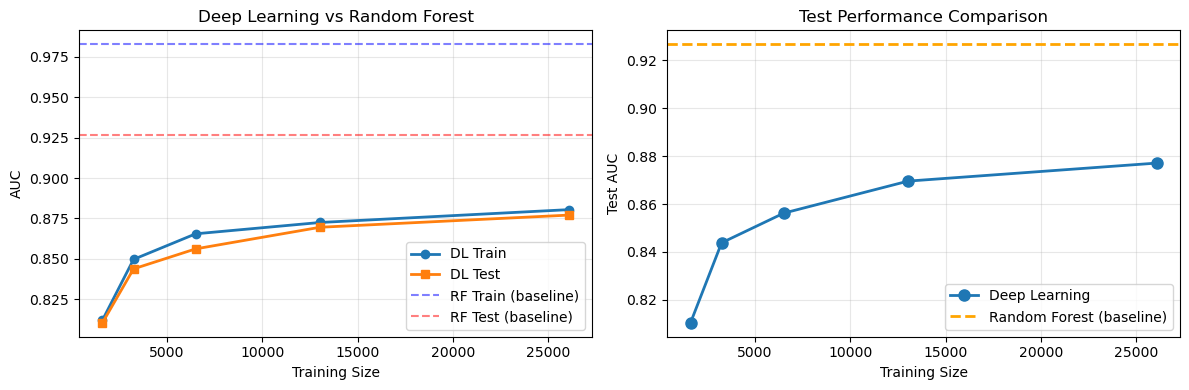

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Deep Learning AUC
axes[0].plot(df['n'], df['dl_train'], 'o-', label='DL Train', linewidth=2)
axes[0].plot(df['n'], df['dl_test'], 's-', label='DL Test', linewidth=2)
# Add RF baseline (only for full data)
axes[0].axhline(y=0.9827, color='blue', linestyle='--', alpha=0.5, label='RF Train (baseline)')
axes[0].axhline(y=0.9266, color='red', linestyle='--', alpha=0.5, label='RF Test (baseline)')
axes[0].set_xlabel('Training Size')
axes[0].set_ylabel('AUC')
axes[0].set_title('Deep Learning vs Random Forest')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Test AUC Comparison
axes[1].plot(df['n'], df['dl_test'], 'o-', label='Deep Learning', linewidth=2, markersize=8)
axes[1].axhline(y=0.9266, color='orange', linestyle='--', linewidth=2, label='Random Forest (baseline)')
axes[1].set_xlabel('Training Size')
axes[1].set_ylabel('Test AUC')
axes[1].set_title('Test Performance Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Observations: Performance Patterns as Data Size Decreases

As training data decreases from n to n/16, Deep Learning test AUC drops from 0.8771 to 0.8105 (7.6% decline), while Random Forest maintains 0.9266 baseline performance. The train-test gap widens with less data, indicating increased overfitting. Deep Learning consistently underperforms Random Forest across all data sizes, with the gap most pronounced at smaller volumes. The visualizations show Deep Learning's test AUC never reaches the Random Forest baseline, suggesting Deep Learning requires substantially more data than available to match Random Forest's performance. For this credit risk dataset with 26k samples, Random Forest is more effective due to Deep Learning's data-hungry nature.